# Imports

In [5]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
set_random_state(42)

# Load dataset

In [7]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3030


In [8]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['shape', 'hemo_aligned', 'gcamp_aligned', 'gcamp_interpolated', 'hemo_interpolated', 'correlation', 'width', 'height', 'start', 'stop', 'file_id', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_mean_centered', 'flow_components', 'mean_sources', 'mean_sinks', 'gcamp_mean'])

# Load data for features, select slow waves

In [9]:
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

#Filter waves and get all data for filtered indices (where)
where = corr < .3
where[height/width < 0.1] = False
where[left_too_high] = False
#where[height/width < 0.05] = False

print(np.sum(where))
    
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


205


In [10]:
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

Text(0, 0.5, 'Absolute frequency')

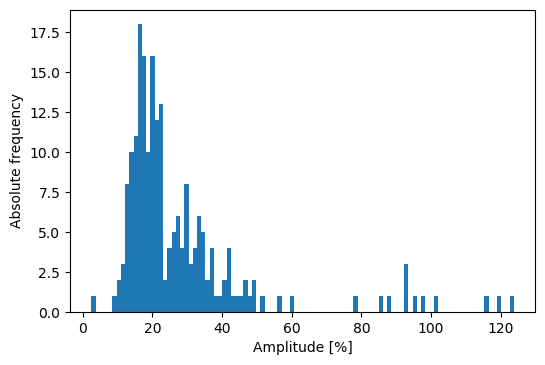

In [11]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(np.sort(height), bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

In [12]:
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)
relative_components = np.array([normalize(c) for c in components])
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

In [13]:
abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])

ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]

ratio_vertical_horizontal = ud/(ud+lr)

In [34]:
abs_up_flow - abs_down_flow

array([-7.75726279e-04,  1.49286736e-03,  4.32974630e-05,  1.30977649e-02,
        1.70452765e-03,  1.99755747e-03,  1.40607613e-03, -2.01070561e-05,
       -1.00160949e-04, -2.07145163e-03,  1.10207614e-03,  1.42538454e-03,
        2.49085180e-03,  8.18756688e-03,  3.62664252e-03, -1.31638371e-03,
        1.95256689e-05,  4.70047630e-03,  1.41400974e-02,  1.05040856e-02,
        3.70899308e-03,  5.45784272e-03,  1.14509491e-02,  1.07603637e-03,
        1.36066484e-03,  4.02630121e-02,  6.88763976e-04,  1.76538825e-02,
        4.10039560e-04, -8.04089010e-04,  1.47452042e-03,  2.87626265e-03,
        1.15211643e-02,  1.46280008e-03,  4.69933869e-03,  4.31544706e-03,
        2.01653177e-03,  1.83784892e-03, -3.90136702e-05,  5.34701510e-04,
       -1.29330001e-04,  5.36703228e-05, -1.74449160e-05,  2.01418577e-03,
        6.28985930e-04,  1.77530153e-03, -4.59165603e-04,  7.03261839e-03,
        1.35923643e-03, -4.15164558e-03,  2.44582305e-03,  2.51793710e-04,
       -6.38563652e-05,  

In [14]:
#for uf in [up_flow[iso == i] for i in list(set(isos))]:
#    plt.scatter(np.arange(len(uf)), uf)
#    plt.plot([0,60], [np.mean(uf), np.mean(uf)])

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [15]:
from sklearn.model_selection import train_test_split
def prepare_data(gcamp, width, height, additional_features, additional_arrays, random_state = 42, test_size=.25, batch_size = 100):
    x = [gcamp.T, height.T, width.T]
    x.extend([f.T for f in additional_features])
    x = np.vstack(x).T
    x[:,128:128+2] = normalize_nan(x[:,128:128+2])#Normalize heights & widths
    
    x_train, x_test = train_test_split(x, test_size=test_size, random_state = random_state)
    arrays_train, arrays_test = train_test_split(additional_arrays, test_size=test_size, random_state = random_state)
    
    #Save additional features seperately
    additional_features_train = []
    additional_features_test = []
    for i in range(len(additional_features)):
        feature_train = x_train[:,130+i]
        feature_test = x_test[:,130+i]
        additional_features_train.append(feature_train)
        additional_features_test.append(feature_test) 
        
    #x_train and x_test are the gcamp signal and the width/ height (aka amplitude, phase of it)
    x_train = x_train[:,:130]
    x_test = x_test[:,:130]
    return x_train, x_test, additional_features_train, additional_features_test, arrays_train, arrays_test
    

In [16]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]

In [17]:
x_train, x_test, add_train, add_test, sources_sinks_train, sources_sinks_test = prepare_data(gcamp, width, height, additional_features, sources_sinks)

In [18]:
x_test.shape

(52, 130)

Save additional features as variables.

In [19]:
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_tests, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

## Remove class imbalance

Large slow waves are present less frequently. Hence optimization will be effected less by these samples (Note that training samples are normalized hence large amplitude waves do not cause greater loss). To avoid slective underfitting of large waves we balance the sampels with respect to height classes. 

In [20]:
height_classes = np.round(height_train*2, -1)
height_classes[height_classes > 50] = 50

In [21]:
upsampled_x_train = resample(x_train, stratify=height_classes, n_samples = 4000, random_state = 42)

In [22]:
print("There are " + str(len(iso_test)) + " test samples")

There are 52 test samples


In [23]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [24]:
## network parameters
from predictive_modeling.models.vae_cnn_v0 import *
from keras import Model

batch_size = 100
epochs = 200

In [25]:
[image_input, value_input], [z_mean, z_log_var, z] = encoder()
latent_inputs, [image_decoded, values_decoded] = decoder()
encoder_model = Model(inputs = [image_input, value_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded], name='decoder')
image_decoded, values_decoded = decoder_model(encoder_model([image_input, value_input])[2])
vae = Model(inputs = [image_input, value_input], outputs = [image_decoded, values_decoded], name='vae_mlp')

../../predictive_modeling/models/vae_cnn_v0.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v0.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v0.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


In [26]:
import keras
vae.add_loss(get_vae_loss(image_input, value_input, image_decoded, values_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100))
#vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [27]:
#model train [sources_sinks_train, x_train]

In [28]:
sources_sinks_train1 = np.expand_dims(sources_sinks_train,-1)
x_train_combined = [np.array(sources_sinks_train1), x_train]

sources_sinks_test1 = np.expand_dims(sources_sinks_test,-1)
x_test_combined = [np.array(sources_sinks_test1), x_test]

In [29]:
# train the autoencoder
history = vae.fit(x_train_combined, validation_data = (x_train_combined, None), epochs=1000, batch_size=batch_size, verbose=1)

Train on 153 samples, validate on 153 samples
Epoch 1/1000
153/153 [==============================] - 6s 41ms/step - loss: 229.1627 - val_loss: 224.8422
Epoch 2/1000
153/153 [==============================] - 1s 8ms/step - loss: 226.3458 - val_loss: 221.0708
Epoch 3/1000
153/153 [==============================] - 1s 8ms/step - loss: 219.1438 - val_loss: 217.6331
Epoch 4/1000
153/153 [==============================] - 1s 7ms/step - loss: 217.4238 - val_loss: 214.4387
Epoch 5/1000
153/153 [==============================] - 1s 7ms/step - loss: 214.8168 - val_loss: 210.4753
Epoch 6/1000
153/153 [==============================] - 1s 8ms/step - loss: 209.4147 - val_loss: 206.0616
Epoch 7/1000
153/153 [==============================] - 1s 7ms/step - loss: 206.5494 - val_loss: 203.4532
Epoch 8/1000
153/153 [==============================] - 1s 7ms/step - loss: 202.0718 - val_loss: 197.6362
Epoch 9/1000
153/153 [==============================] - 1s 7ms/step - loss: 198.1010 - val_loss: 194.4915

153/153 [==============================] - 1s 6ms/step - loss: 79.2393 - val_loss: 78.9614
Epoch 79/1000
153/153 [==============================] - 1s 6ms/step - loss: 79.3156 - val_loss: 78.6682
Epoch 80/1000
153/153 [==============================] - 1s 6ms/step - loss: 78.3977 - val_loss: 78.0721
Epoch 81/1000
153/153 [==============================] - 1s 6ms/step - loss: 77.9633 - val_loss: 77.7688
Epoch 82/1000
153/153 [==============================] - 1s 6ms/step - loss: 77.6975 - val_loss: 77.2272
Epoch 83/1000
153/153 [==============================] - 1s 5ms/step - loss: 77.2935 - val_loss: 77.1300
Epoch 84/1000
153/153 [==============================] - 1s 6ms/step - loss: 76.9564 - val_loss: 76.6199
Epoch 85/1000
153/153 [==============================] - 1s 6ms/step - loss: 76.6714 - val_loss: 76.5185
Epoch 86/1000
153/153 [==============================] - 1s 6ms/step - loss: 76.5021 - val_loss: 76.2178
Epoch 87/1000
153/153 [==============================] - 1s 6ms/step 

KeyboardInterrupt: 

In [ ]:
plt.plot(vae.history.history["val_loss"])

In [65]:
res = vae.predict([np.array(sources_sinks_train1), x_train])

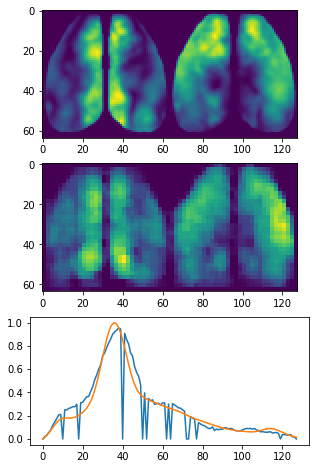

In [145]:
i = 3
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[1][i][:-2])
ax[2].plot(x_train[i][:-2])

In [143]:
z_train = encoder_model.predict([np.array(sources_sinks_train1), x_train])[2].T

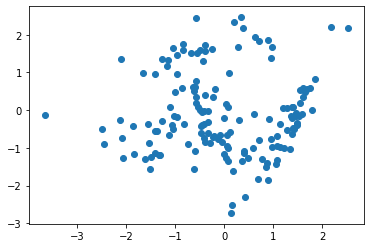

In [144]:
plt.scatter(*z_train)

# Visualization

In [ ]:
vae.

In [1]:
fig, ax = plt.subplots(1,2, figsize= (10, 3), dpi = 200)


ax[0].scatter(components[:,0],components[:,1])
ax[0].set_xlabel("Sum of leftwards flow")
ax[0].set_ylabel("Sum of rightwards flow")

ax[1].scatter(components[:,2],components[:,3])
ax[1].set_xlabel("Sum of upwards flow")
ax[1].set_ylabel("Sum of downwards flow")

NameError: name 'plt' is not defined

In [139]:
from plots import *

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0.        , 0.02381235, 0.0573943 , 0.10403895, 0.16333632,
        0.23215085, 0.30503147, 0.37355349, 0.4269911 , 0.45995161,
        0.46749235, 0.44905234, 0.41153842, 0.35965574, 0.30445...

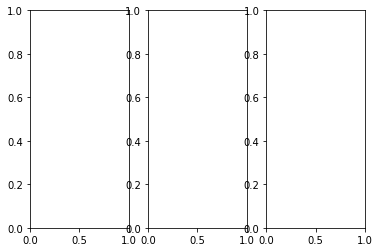

In [140]:
plot_vae_input_output(vae, x_test, [0, 10, 50])

In [ ]:
plt.plot(height_train[iso_train == 1.8])
plt.plot(height_train[iso_train == 2.0])
plt.plot(height_train[iso_train == 2.2])
plt.plot(height_train[iso_train == 2.4])
plt.plot(height_train[iso_train == 2.6])

In [ ]:
isos = [1.8, 2.0, 2.2, 2.4, 2.6]
fig, ax = plt.subplots(1, 3, figsize = (12, 2), dpi = 300)

vecs_vert_horiz = []
vecs_up_flow = []
vecs_left_flow = []

isos = [1.8, 2.0, 2.2, 2.4, 2.6]

for iso_level in isos:
    where = iso == iso_level
    #print(np.mean(ratio_vertical_horizontal[where]))
    vec_vert_horiz = ratio_vertical_horizontal[where]
    vecs_vert_horiz.append(vec_vert_horiz)
    
    vec_up_flow = up_flow[where]
    vecs_up_flow.append(vec_up_flow)
    
    vec_left_flow = left_flow[where]
    vecs_left_flow.append(vec_left_flow)
    
_ = ax[0].boxplot(np.array(vecs_vert_horiz)*100)
_ = ax[1].boxplot(np.array(vecs_up_flow)*100)
_ = ax[2].boxplot(np.array(vecs_left_flow)*100)

ax[0].set_title("Vertical / total flow [%]")
ax[1].set_title("Bottom-up / vertical flow [%]")
ax[2].set_title("Medial-lateral / horizontal flow [%]")

for i in range(len(ax)):
    ax[i].set_xticklabels(isos)
    ax[i].set_xlabel("isofluorane [%]")
    
for i, a in enumerate(ax):
    ax[i].text(-0.1, 1.1, string.ascii_uppercase[i], transform = a.transAxes, size= 15, weight = "bold")


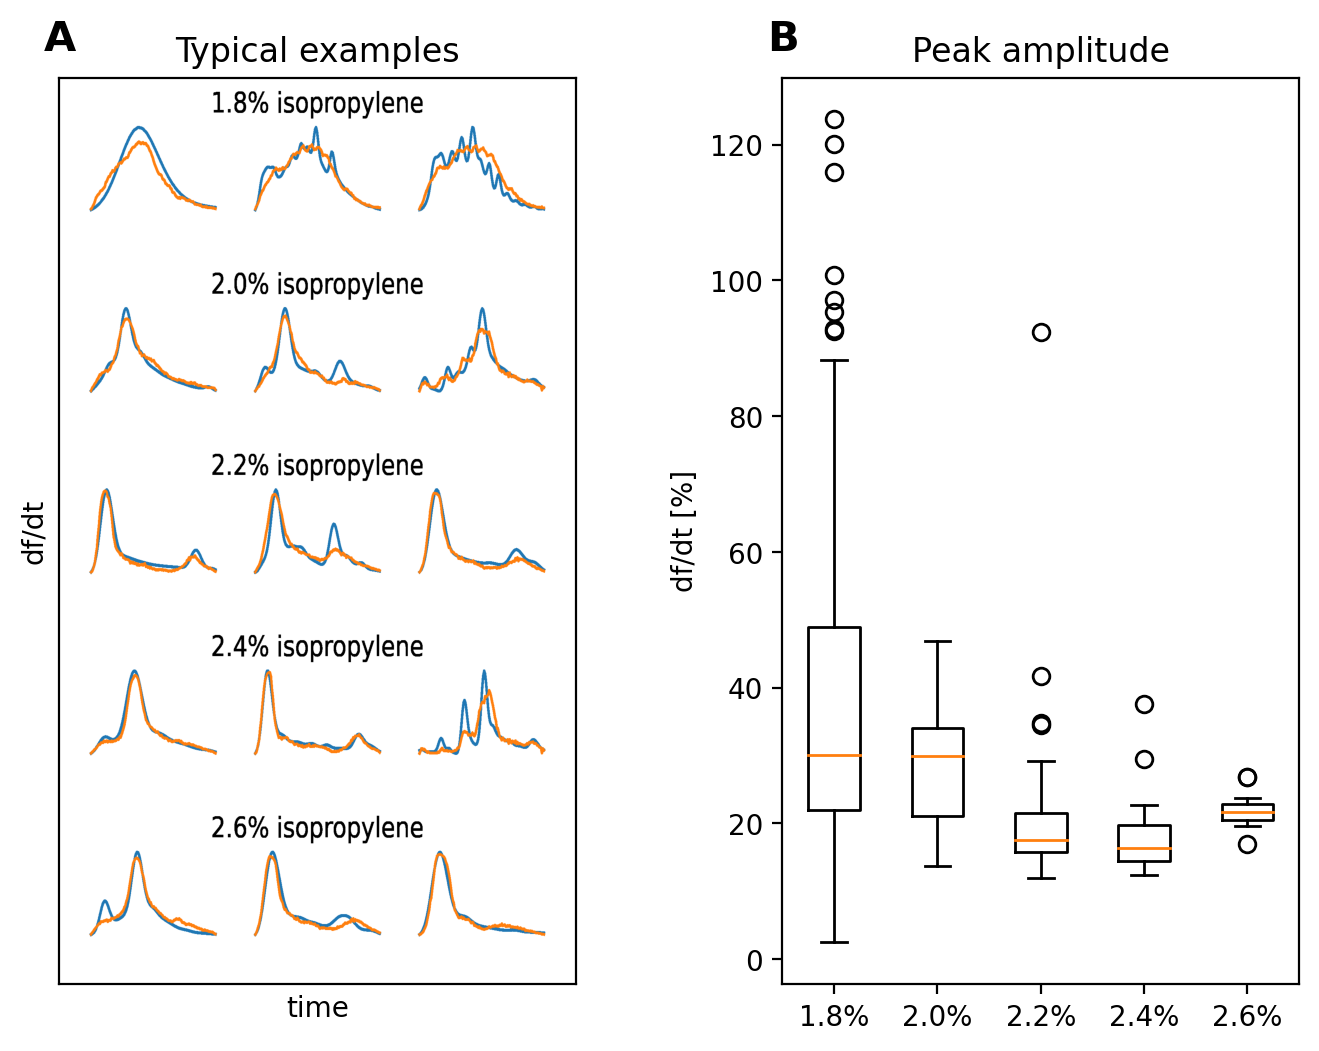

In [454]:
idxs = [[6,7,11], [0, 4,2], [0,1, 2], [0,1, 4], [12,1, 2]]
fig = plot_examples_and_boxplot_heights(vae, x_train, iso_train, height_train, idxs = idxs)
fig.savefig("typical_examples_and_sw_peak_amplitudes.png")

In [112]:
#plot_feature_in_latent_space(encoder, x_train, iso_train)

In [113]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder.predict(x_train)[2].T
x_pred_test, y_pred_test = encoder.predict(x_test)[2].T

In [145]:
%%capture
if False:
    x_range = [np.min(x_pred_train), np.max(x_pred_train)]
    y_range = [np.min(y_pred_train),np.max(y_pred_train)]
else:
    x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
    y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
    x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
    y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
    x_range = [x_min, x_max]
    y_range = [y_min, y_max]

res = manifold(decoder, x_range, y_range, n = 15, dpi = 300, scale="sqrt")

/storage/michael/projects/motion_patterns/predictive_modeling/slow_wave_shape_space/plots.py:230: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.show()
/storage/michael/projects/motion_patterns/predictive_modeling/slow_wave_shape_space/plots.py:232: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


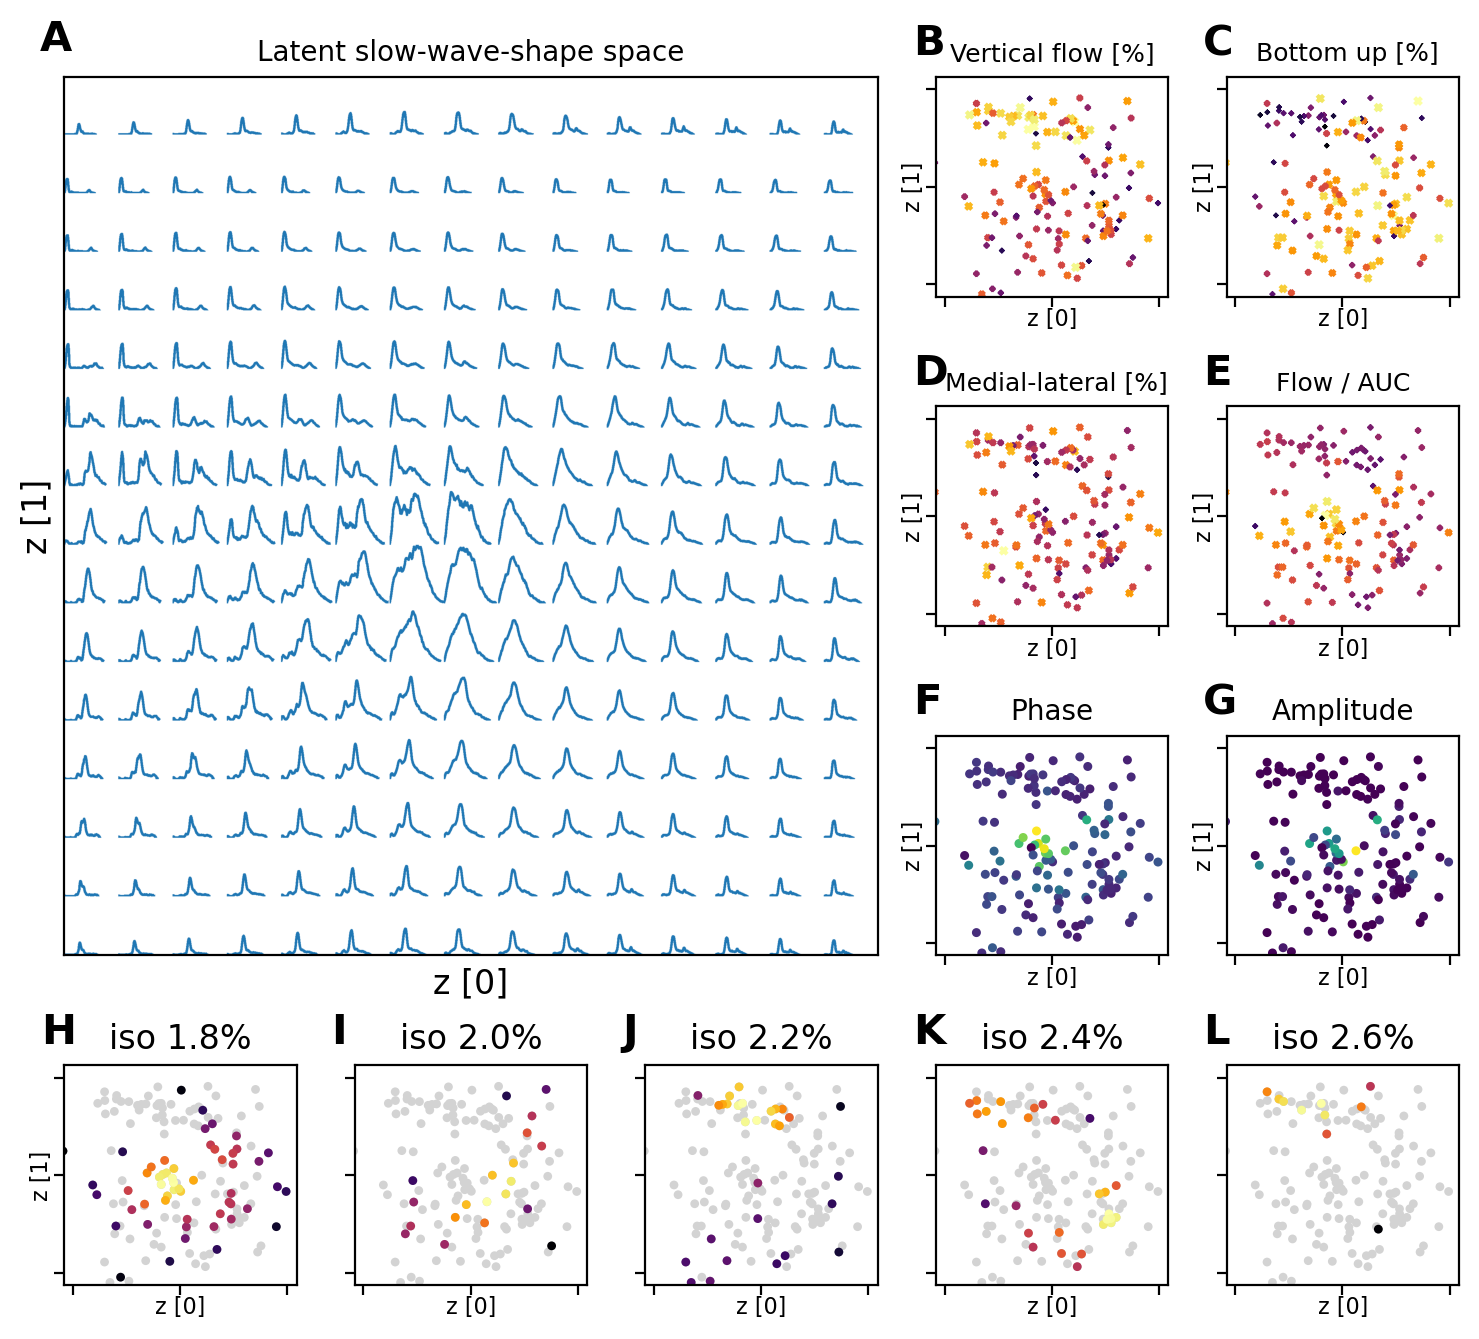

In [439]:
fig = plot_latent_space_and_basic_features_for_substantial_waves(res, iso_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, width_train, height_train, flow_per_auc_train, x_pred_train, y_pred_train, x_range, y_range, dpi = 200)

In [1197]:
fig.savefig("slow_wave_shape_space.png")

In [440]:
%%capture
where = np.where(height_train > 10)
res1 = manifold(decoder, x_range = [np.min(x_pred_train[where]), np.max(x_pred_train[where])], 
                                   y_range = [np.min(y_pred_train[where]),np.max(y_pred_train[where])], n = 10, dpi = 300)

In [442]:
#plot_latent_space_and_basic_features(res1, iso, iso_train[where], corr_train[where], width_train[where], height_train[where], x_pred_train[where], y_pred_train[where])

In [443]:
#plot_latent_space_and_basic_features(res, iso, iso_test, corr_test, width_test, height_test, x_pred_test, y_pred_test)

In [ ]:
latent = np.array(([list([x[0]]) for x in encoder.predict(x_train[1:2])]))

In [ ]:
%%capture
res = manifold(decoder, x_range = [np.min(x_pred_train), np.max(x_pred_train)], 
                                   y_range = [np.min(y_pred_train),np.max(y_pred_train)], n = 15, dpi = 300)

In [ ]:
fig, ax = plt.subplots(1, figsize= (12,12))
ax.imshow(res)
plt.axis("off")